In [ ]:
!nvidia-smi

Wed Jun  7 10:13:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
! pip install plotly -q

In [ ]:
!git clone https://github.com/openai/point-e

Cloning into 'point-e'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 57 (delta 7), reused 51 (delta 7), pack-reused 0
Unpacking objects: 100% (57/57), 1.56 MiB | 458.00 KiB/s, done.


In [ ]:
%cd point-e

/content/point-e


In [ ]:
! pip install -e . -q

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.9 MB/s eta 0:00:00


### Imports

In [ ]:
from PIL import Image
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

### Models

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...


100%|███████████████████████████████████████| 890M/890M [00:11<00:00, 80.2MiB/s]


creating upsample model...
downloading base checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

downloading upsampler checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

<All keys matched successfully>

In [ ]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [ ]:
import os
from PIL import Image
import plotly.graph_objects as go
from point_e.util.pc_to_mesh import marching_cubes_mesh

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

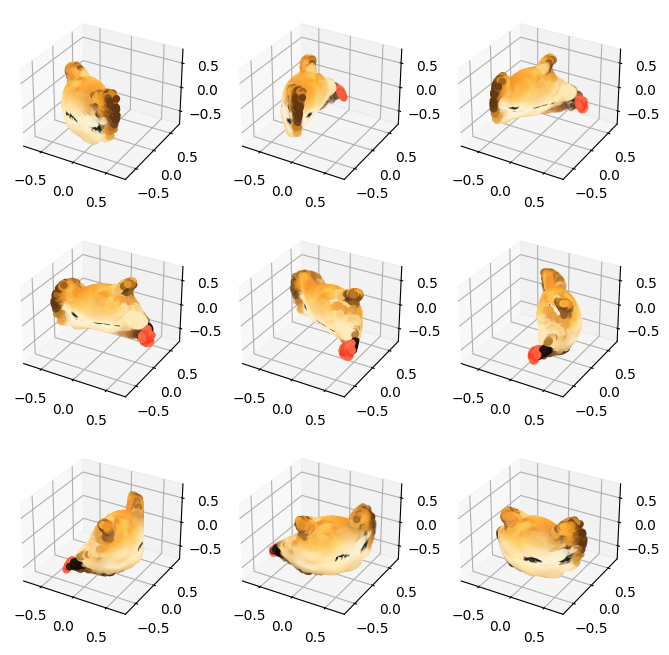

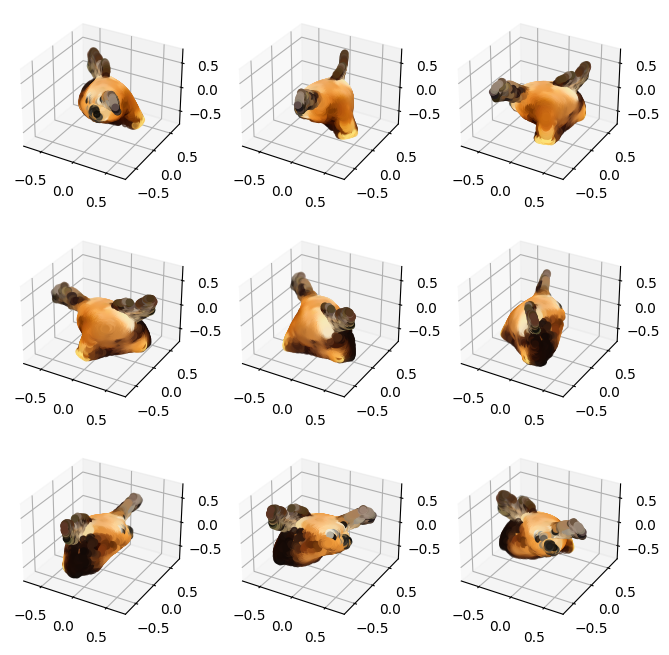

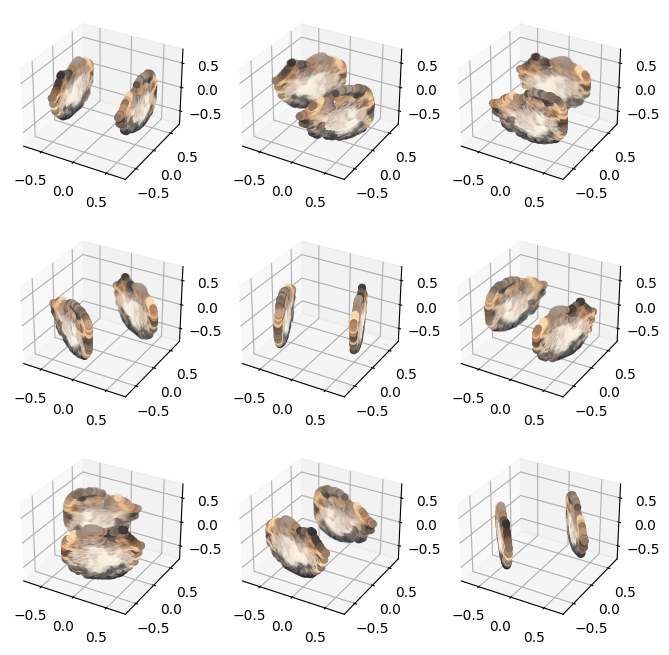

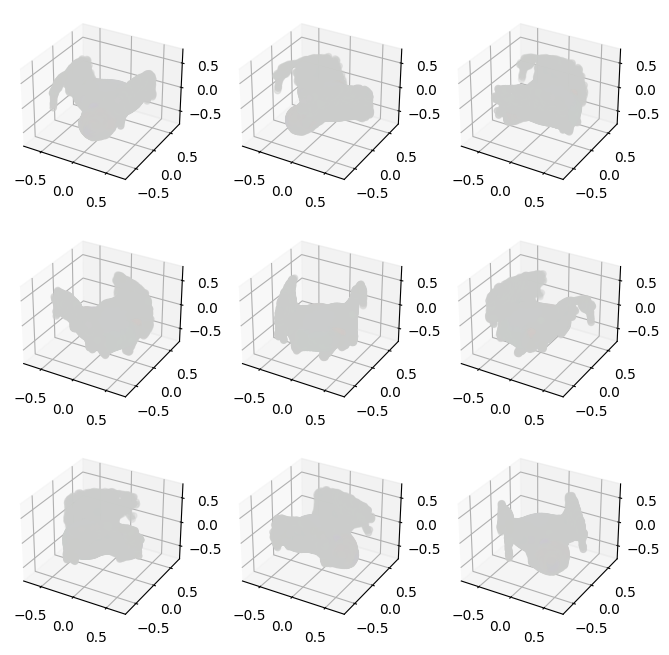

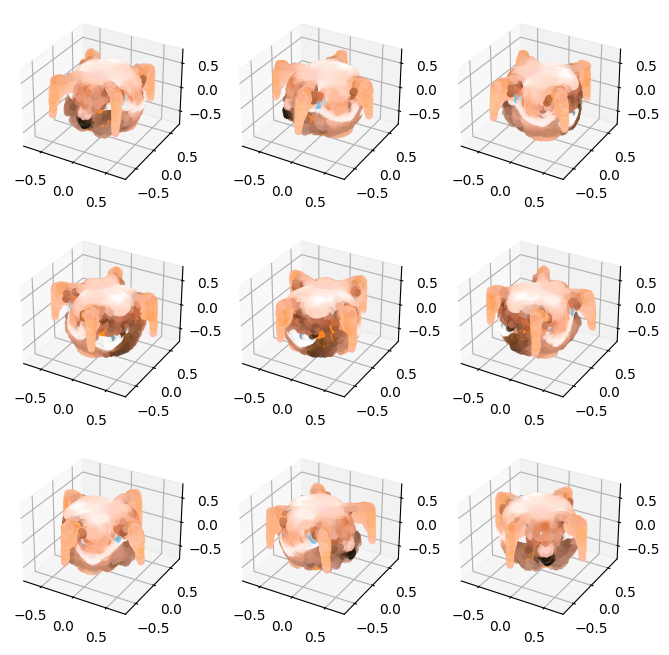

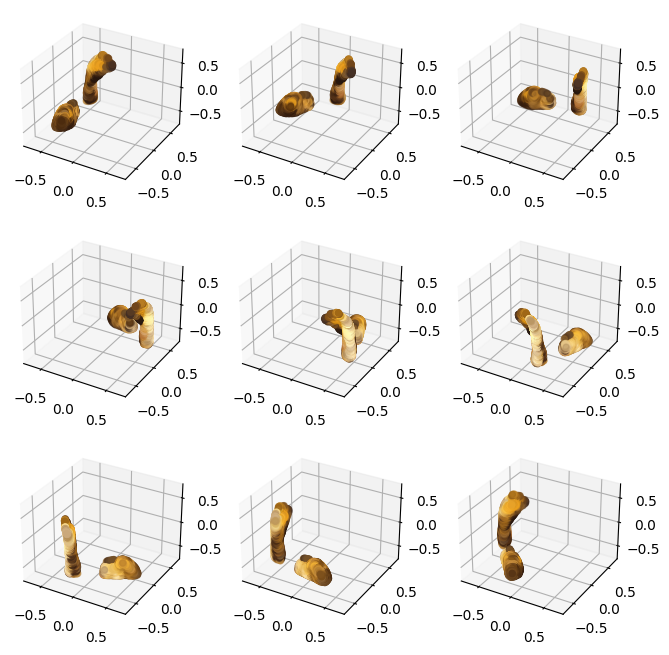

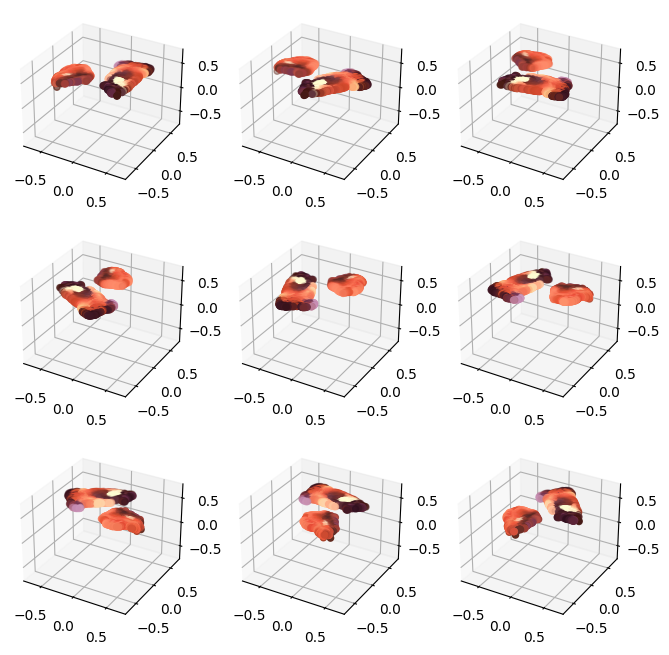

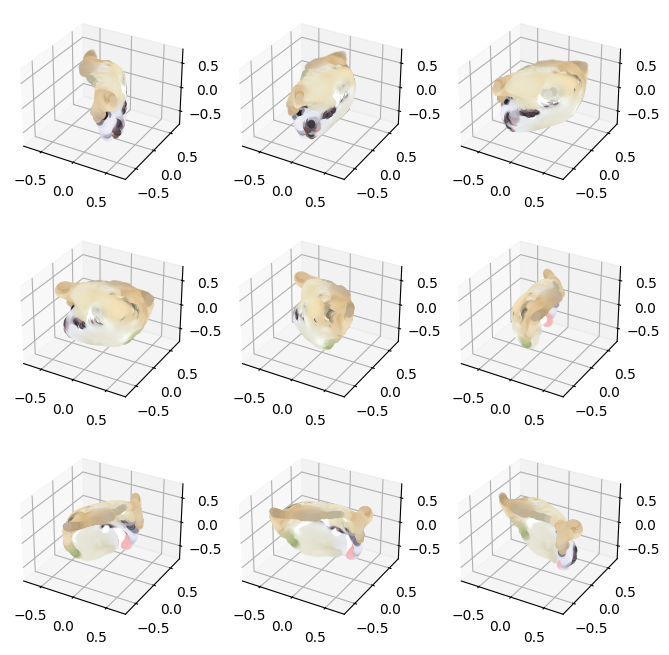

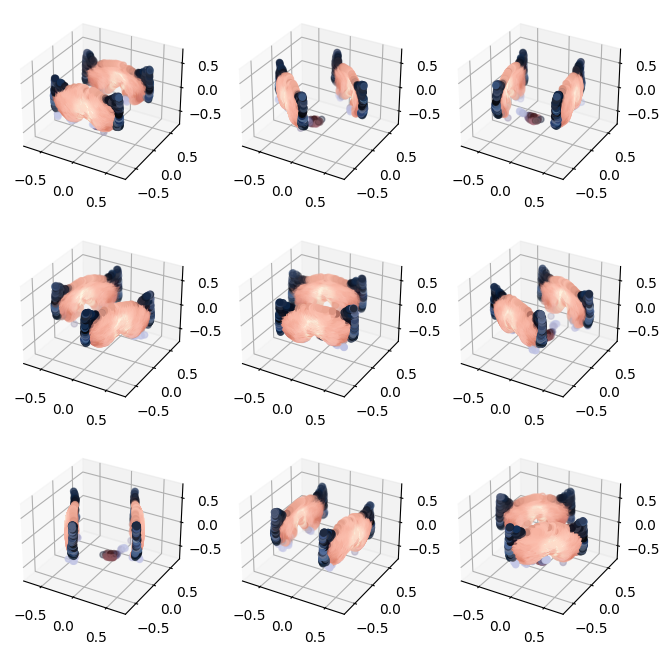

In [ ]:

# from point_e.models import model_from_config
# from point_e.util.checkpoints import load_checkpoint


# Specify the folder path containing the 2D images
folder_path = "/content/sample_data/input_data"

# List all files in the folder
file_list = os.listdir(folder_path)

# Load and process each image in the folder
for file_name in file_list:
    if file_name.endswith(".jpeg"):
        # Load an image to condition on.
        img_path = os.path.join(folder_path, file_name)
        img = Image.open(img_path)

        # Produce a sample from the model.
        samples = None
        for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
            samples = x

        pc = sampler.output_to_point_clouds(samples)[0]
        
        fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))  
        fig_plotly = go.Figure(
        data=[
            go.Scatter3d(
                x=pc.coords[:,0], y=pc.coords[:,1], z=pc.coords[:,2], 
                mode='markers',
                marker=dict(
                  size=2,
                  color=['rgb({},{},{})'.format(r,g,b) for r,g,b in zip(pc.channels["R"], pc.channels["G"], pc.channels["B"])],
              )
            )
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        ),
    )
        fig_plotly.show(renderer="colab")

        # Creating SDF model
        name = 'sdf'
        model = model_from_config(MODEL_CONFIGS[name], device)
        model.eval()

        # Loading SDF model
        model.load_state_dict(load_checkpoint(name, device))

        # Produce a mesh (with vertex colors)
        mesh = marching_cubes_mesh(
            pc=pc,
            model=model,
            batch_size=4096,
            grid_size=32,  # increase to 128 for resolution used in evals
            progress=True,
        )

        # Write the mesh to a PLY file
        output_file_name = os.path.splitext(file_name)[0] + ".ply"
        output_file_path = os.path.join(folder_path, output_file_name)
        with open(output_file_path, 'wb') as f:
            mesh.write_ply(f)


In [ ]:
!zip -r /content/file.zip /content/sample_data/input_data

  adding: content/sample_data/input_data/ (stored 0%)
  adding: content/sample_data/input_data/e1.ply (deflated 60%)
  adding: content/sample_data/input_data/f2.jpeg (deflated 1%)
  adding: content/sample_data/input_data/f3.jpeg (deflated 1%)
  adding: content/sample_data/input_data/e1.jpeg (deflated 1%)
  adding: content/sample_data/input_data/f5.jpeg (deflated 1%)
  adding: content/sample_data/input_data/f4.ply (deflated 60%)
  adding: content/sample_data/input_data/f4.jpeg (deflated 1%)
  adding: content/sample_data/input_data/e2.ply (deflated 57%)
  adding: content/sample_data/input_data/f5.ply (deflated 63%)
  adding: content/sample_data/input_data/f3.ply (deflated 58%)
  adding: content/sample_data/input_data/e2.jpeg (deflated 5%)
  adding: content/sample_data/input_data/e3.jpeg (deflated 9%)
  adding: content/sample_data/input_data/e4.ply (deflated 60%)
  adding: content/sample_data/input_data/f1.jpeg (deflated 1%)
  adding: content/sample_data/input_data/e4.jpeg (deflated 5%)
 

In [ ]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>